In [22]:
import numpy as np
from astropy.io import fits
import glob
import matplotlib.pyplot as plt  
from matplotlib.animation import FuncAnimation, PillowWriter
from photutils import CircularAperture
from astropy.visualization import SinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SinhStretch())

SMALL_SIZE = 32
MEDIUM_SIZE = 36
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [45]:
def create_circular_mask(h, w, center=None, radius=None, leq=False):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    if leq is False:
        return dist_from_center >= radius
    else:
        return dist_from_center <= radius

def domask(img, inn=70, outt=180):
    outermask = create_circular_mask(451, 451, radius=outt, leq=True)
    img[~outermask] = np.nanmedian(img)#np.nan
    mask = create_circular_mask(451, 451, radius=inn)
    masked_img = img.copy()
    masked_img[~mask] = np.nanmedian(img)#np.nan
    return masked_img

In [60]:
imlist = glob.glob('../forwardModel/output/*/Ha*/doGaussian/*klipped*.fits')
print(imlist)

['../forwardModel/output/15May15/Ha_40pct/doGaussian/Ha_40pct4.569-klipped-KLmodes-all.fits', '../forwardModel/output/8Apr14/Ha/doGaussian/Ha4.897-klipped-KLmodes-all.fits', '../forwardModel/output/18May15/Ha_60pct/doGaussian/Ha_60pct3.82-klipped-KLmodes-all.fits', '../forwardModel/output/11Apr13/Ha_60pct/doGaussian/Ha_60pct3.122-klipped-KLmodes-all.fits', '../forwardModel/output/27Apr18/Ha/doGaussian/Ha3.578-klipped-KLmodes-all.fits', '../forwardModel/output/16May15/Ha_90pct/doGaussian/Ha_90pct3.755-klipped-KLmodes-all.fits']


In [61]:
imlist = imlist[3:4]+imlist[1:2]+imlist[0:1]+imlist[5:]+imlist[2:3]+imlist[4:5]
print(imlist)

['../forwardModel/output/11Apr13/Ha_60pct/doGaussian/Ha_60pct3.122-klipped-KLmodes-all.fits', '../forwardModel/output/8Apr14/Ha/doGaussian/Ha4.897-klipped-KLmodes-all.fits', '../forwardModel/output/15May15/Ha_40pct/doGaussian/Ha_40pct4.569-klipped-KLmodes-all.fits', '../forwardModel/output/16May15/Ha_90pct/doGaussian/Ha_90pct3.755-klipped-KLmodes-all.fits', '../forwardModel/output/18May15/Ha_60pct/doGaussian/Ha_60pct3.82-klipped-KLmodes-all.fits', '../forwardModel/output/27Apr18/Ha/doGaussian/Ha3.578-klipped-KLmodes-all.fits']


In [47]:
inner = [7, 7, 7, 7, 7, 4]

In [62]:
imcube = np.zeros((len(imlist),451,451))
i = 0
from pyklip.klip import nan_gaussian_filter
for im in imlist:
    imdata = nan_gaussian_filter(fits.getdata(im), 1)
    imdata = imdata[0]
    imdata[np.isnan(imdata)] = np.nanmedian(imdata)
    imcube[i] = domask(imdata, inn=inner[i])
    i += 1

/usr/local/src/pyklip/pyklip/klip.py:571: RuntimeWarning: invalid value encountered in true_divide
  filtered /= filter_norm


In [63]:
maxes = []
for im in imcube:
    indices = np.where(im == np.nanmax(im))
    print(indices)
    coords = list(zip(indices[1], indices[0]))
    print(coords)
    if coords[0][0] > 222:
        indices = np.where(im == np.partition(im.flatten(), -2)[-2])
        coords2 = list(zip(indices[1], indices[0]))
        if coords2[0][0] > 222:
            indices = np.where(im == np.partition(im.flatten(), -5)[-5])
            coords2 = list(zip(indices[1], indices[0]))
        maxes.append(coords2)
    else:
        maxes.append(coords)
print(maxes)
# maxes[2][0] = (217,222)


(array([219]), array([217]))
[(217, 219)]
(array([220]), array([216]))
[(216, 220)]
(array([222]), array([217]))
[(217, 222)]
(array([222]), array([216]))
[(216, 222)]
(array([222]), array([216]))
[(216, 222)]
(array([229]), array([219]))
[(219, 229)]
[[(217, 219)], [(216, 220)], [(217, 222)], [(216, 222)], [(216, 222)], [(219, 229)]]


In [64]:
lims = []
for im in imcube:
    mi = im.min()
    ma = im.max()
    lims.append([mi,ma])
lims[1][0] = -20
lims[1][1] = 30
lims

[[-6.641823426642295, 14.113595375032862],
 [-20, 30],
 [-5.312372240108538, 12.072733738079119],
 [-24.258954682405015, 24.300919921006745],
 [-168.83061431341264, 370.1839014773566],
 [-9.422358351517598, 13.533807866161109]]

In [65]:
date = []
for im in imlist:
    d = im.replace('../forwardModel/output/', '')
    d = d.split('/')
    d = d[0]
    if d == '8Apr14_short':
        d = d.replace('_short', '')
    date.append(d)
date

['11Apr13', '8Apr14', '15May15', '16May15', '18May15', '27Apr18']

In [66]:
from photutils.aperture import CircularAnnulus, aperture_photometry
from photutils.centroids import centroid_com
posishs = []
fluxs = []
flux_errs = []
fwhms = [4,5.5,5.01,5.24,4.49,5.5,4.22]
for i in range(len(imlist)):
    data = imcube[i]
    aprad = 3
    xguess, yguess = maxes[i][0]
    centroid = centroid_com(data[yguess-2:yguess+2,xguess-2:xguess+2])
    centroid[0] += xguess-2
    centroid[1] += yguess-2
    apertures = CircularAperture(maxes[i][0], r=aprad)
#     apertures.plot(color='cyan', lw=1.5, alpha=0.6)
    radius = np.sqrt((maxes[i][0][0]-225)**2-(maxes[i][0][1]-225)**2)
#     print(radius)
#     print(apertures)
    ap_table = aperture_photometry(data, apertures)
    for col in ap_table.colnames:
        ap_table[col].info.format = '%.8g'  # for consistent table output
    apsum = ap_table['aperture_sum'][0]
    try:
        rin = int(radius)-2
        rout = int(radius)+2
        annulus_aperture = CircularAnnulus((225,225), r_in=rin, r_out=rout)
    except ValueError:
        rin = int(radius)
        rout = int(radius)+2
        annulus_aperture = CircularAnnulus((225,225), r_in=rin, r_out=rout)
#     print(annulus_aperture)
    ann_table = aperture_photometry(data, annulus_aperture)
    for col in ann_table.colnames:
        ann_table[col].info.format = '%.8g'  # for consistent table output
    annsum = ann_table['aperture_sum'][0]
    annarea = (np.pi*rout**2)-(np.pi*rin**2)
    aparea = np.pi*aprad**2
    bkg = (annsum/annarea)*aparea
    final = apsum-bkg
    
    # flux error
    annulus_masks = annulus_aperture.to_mask(method='center')
    annulus_data = annulus_masks.multiply(data)
    mask = annulus_masks.data
    annulus_data_1d = annulus_data[mask > 0]
#     from astropy.stats import sigma_clipped_stats
#     _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    flux_errs.append(np.std(annulus_data_1d))
#     flux_errs.append(median_sigclip)

    
    
#     print(centroid)
#     print(final)
    posishs.append(centroid)
    fluxs.append(final)

def angle_between(p1, p2):
    deltaX = p1[0]-p2[0]
    deltaY = p1[1]-p2[1]
    return 180 - np.arctan2(deltaX, deltaY)/np.pi*180

def calcDistance(x0, y0, x1, y1):
    return np.sqrt((x1 - x0)**2 + (y1-y0)**2)

seps = []
angs = []
angerrs = []
for i in range(len(posishs)):
    x, y = posishs[i]
    flux = fluxs[i]
    sep = calcDistance(225,225,x,y)
    seps.append(sep)
    ang = angle_between((x,y),(225,225))-180
    angerr1 = angle_between((x+fwhms[i],y+fwhms[i]), (225,225))-180
    angs.append(ang)
    angerr = angerr1-ang
    angerrs.append(angerr)

import pandas as pd
table = [date,seps, angs, angerrs, fluxs, flux_errs]
table = pd.DataFrame(table).transpose()
table.columns = ['date','sep','pa','pa_err','flux','flux_err']
table.to_clipboard()

In [67]:
expectedx = 6.2*np.cos(np.radians(78+90))
expectedy = 6.2*np.sin(np.radians(78+90))
x17 = expectedx+225
y17 = expectedy+225

<ipython-input-70-1272ea24ea63>:9: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.imshow(domask(imcube[i], inn=inner[i], outt=20), origin='lower', norm=norm, vmin=lims[i][0], vmax=lims[i][1], cmap='inferno')


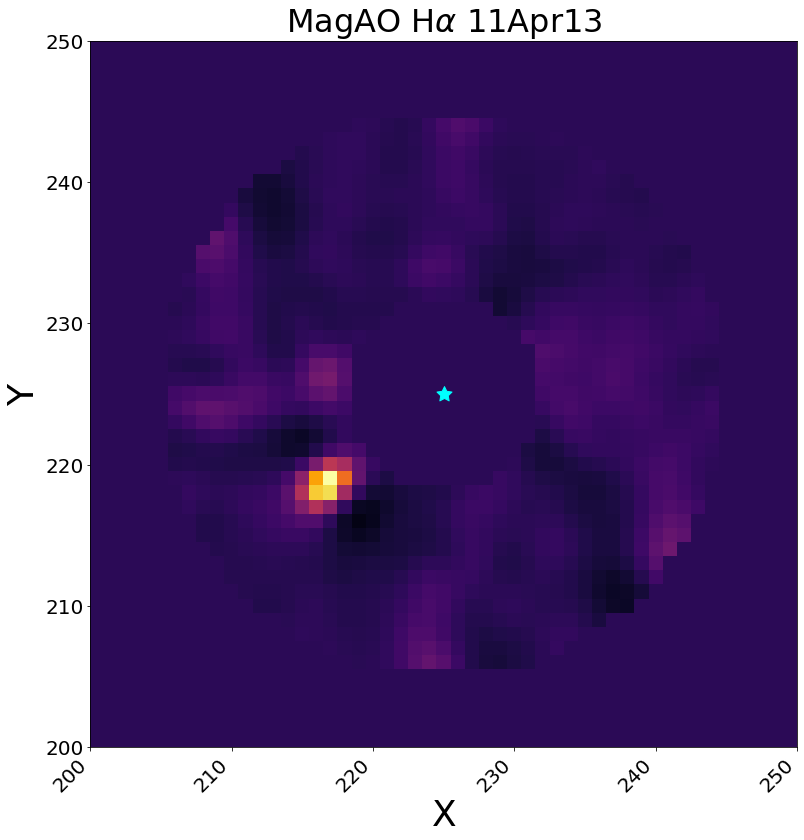

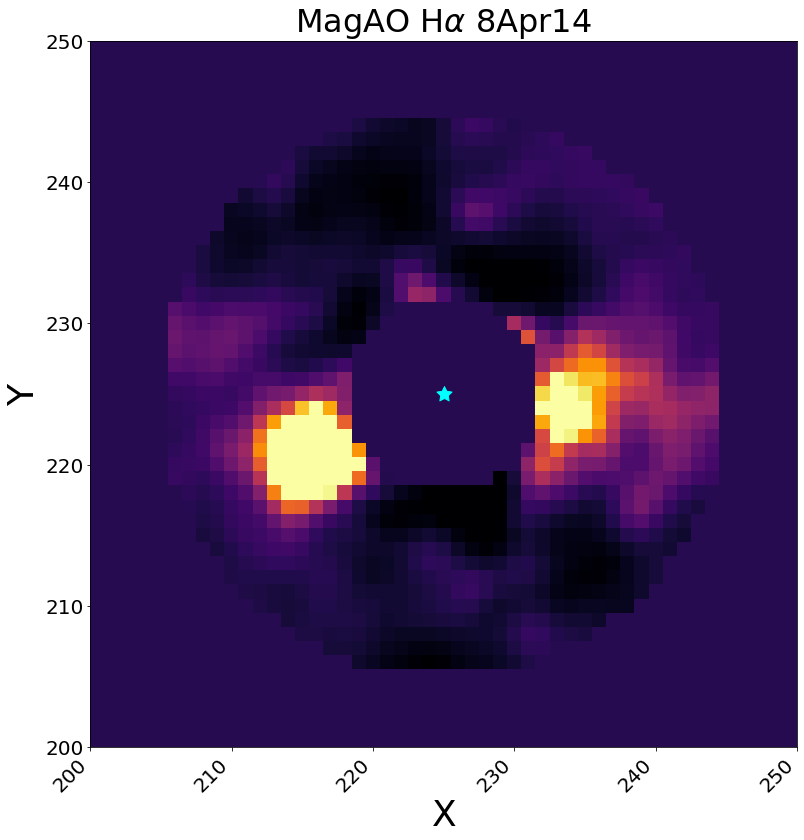

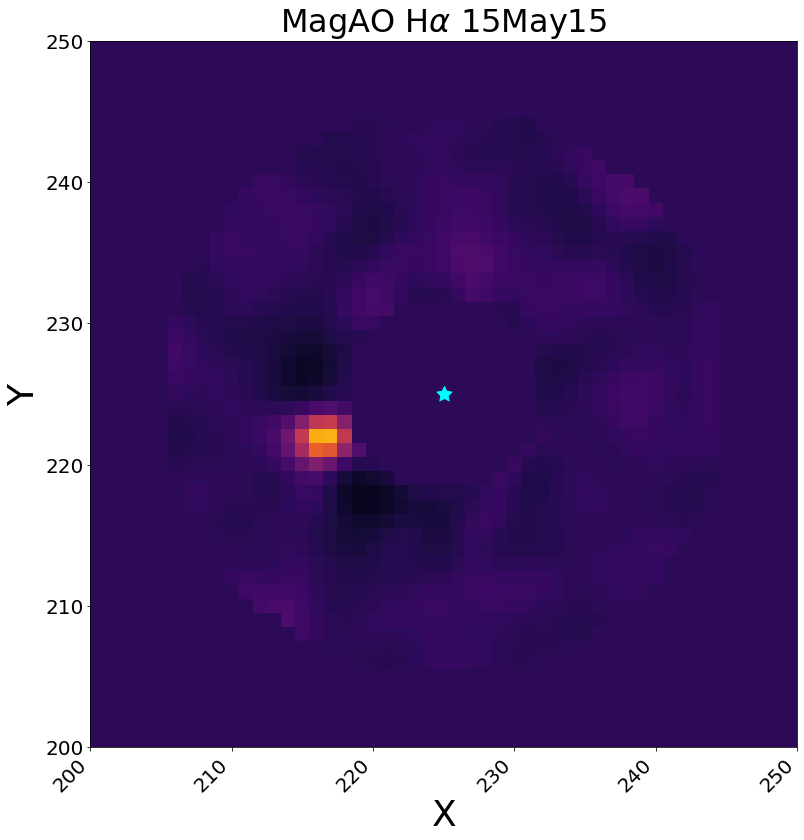

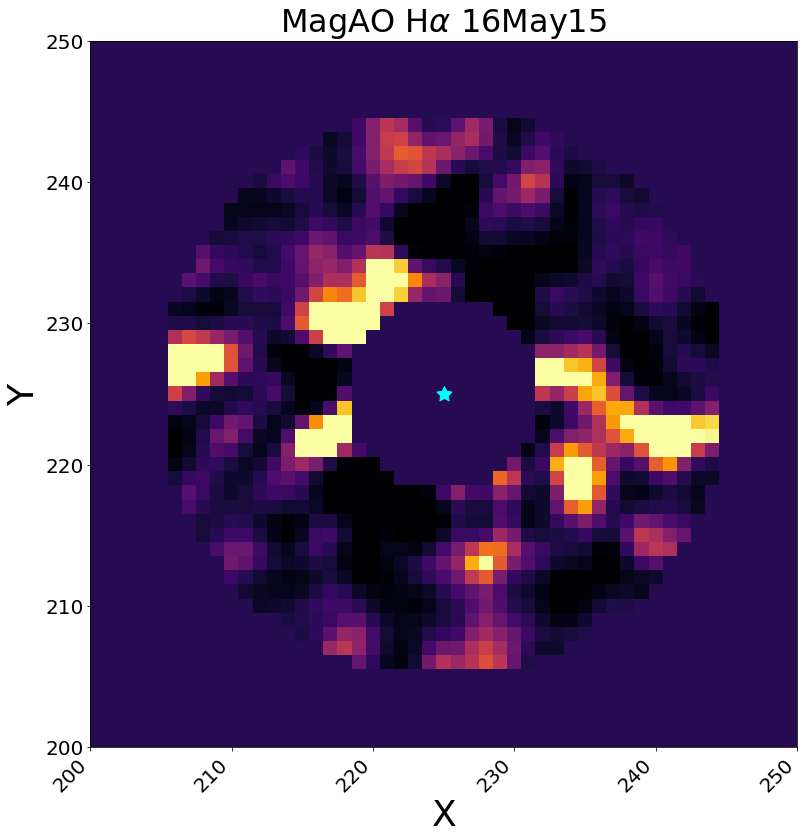

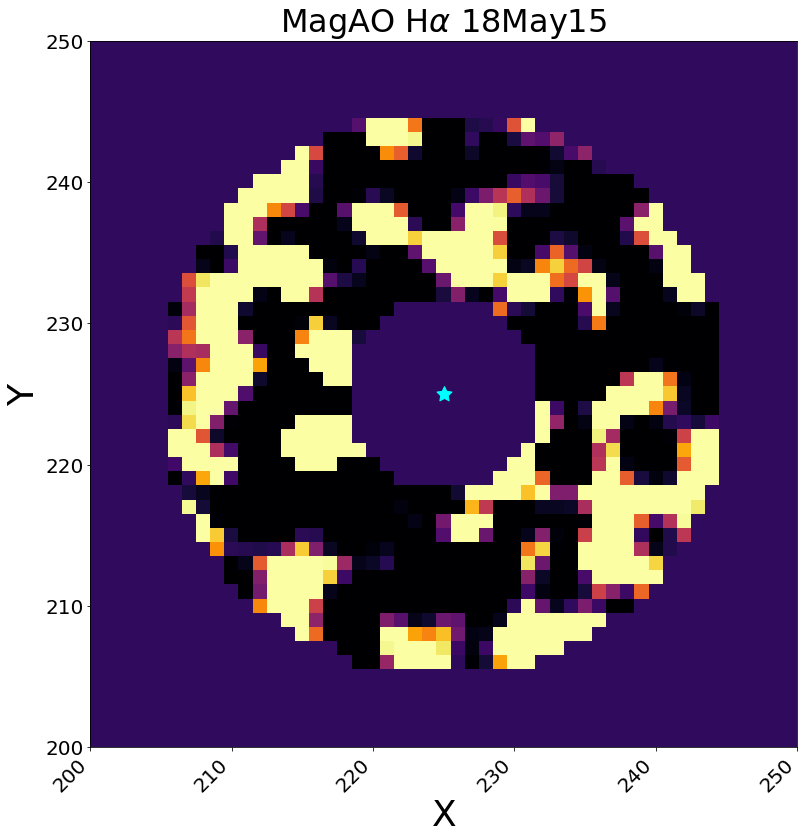

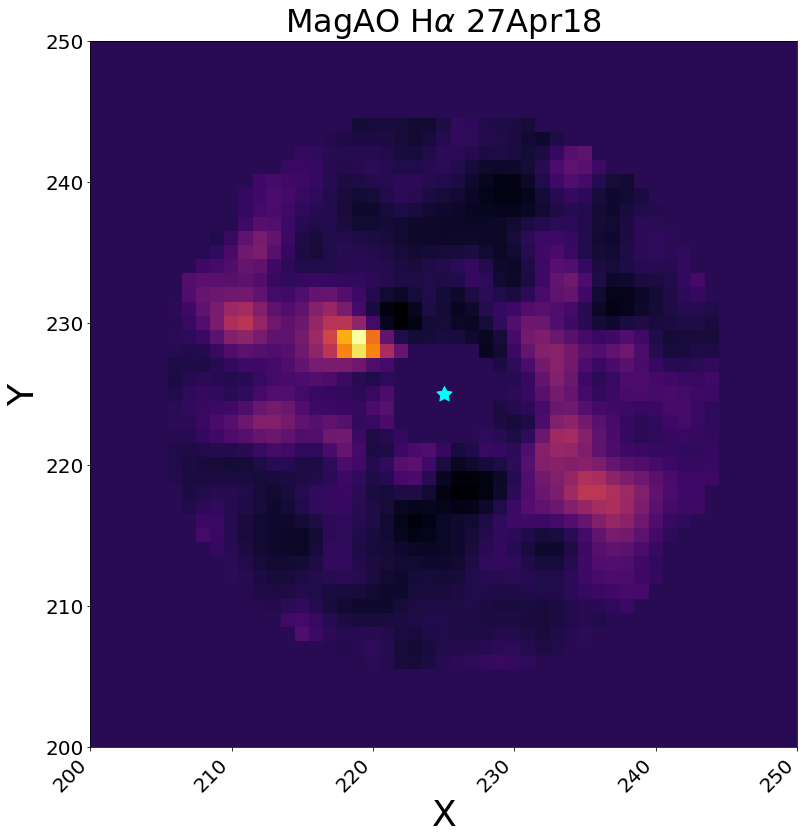

In [70]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio

def plot_for_offset(i, saveindiv=False):
    fig, ax = plt.subplots(figsize=(13,13))
    fig.patch.set_alpha(0)
    ax.imshow(domask(imcube[i], inn=inner[i], outt=20), origin='lower', norm=norm, vmin=lims[i][0], vmax=lims[i][1], cmap='inferno')
    ax.scatter([225], [225], c='cyan', s=250, marker=(5, 1))
#     apertures = CircularAperture(maxes[i], r=3)
#     apertures.plot(color='cyan', lw=1.5, alpha=0.6)
#     apertures = CircularAperture((x17,y17), r=2)
#     apertures.plot(color='red', lw=1.5, alpha=0.8)
    ax.plot()
    ax.set(xlabel='X', ylabel='Y')
    plt.xticks(rotation=45, ha="right", fontsize=20)
    plt.yticks(ha="right", fontsize=20)
    plt.title(r'MagAO H$\alpha$ {}'.format(date[i]))

    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant
    ax.set_xlim(200, 250)
    ax.set_ylim(200, 250)

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    if saveindiv is True:
        plt.savefig(date[i]+'_orbit.png', dpi=200)

    return image

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./orbit_nolabel.gif', [plot_for_offset(i) for i in range(len(imlist))], fps=1)

<ipython-input-70-1272ea24ea63>:9: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.imshow(domask(imcube[i], inn=inner[i], outt=20), origin='lower', norm=norm, vmin=lims[i][0], vmax=lims[i][1], cmap='inferno')


[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

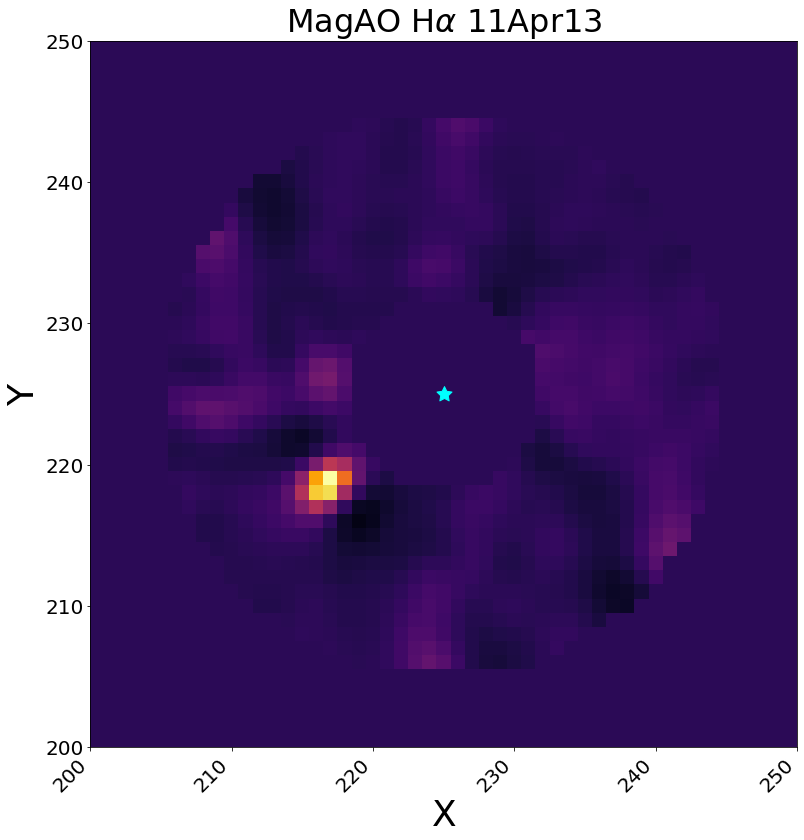

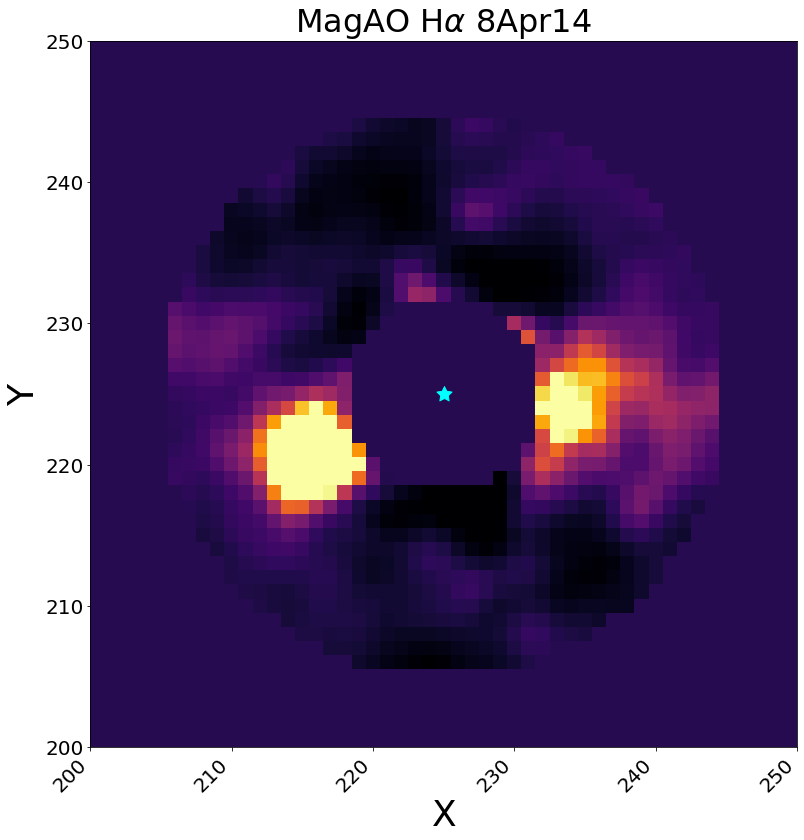

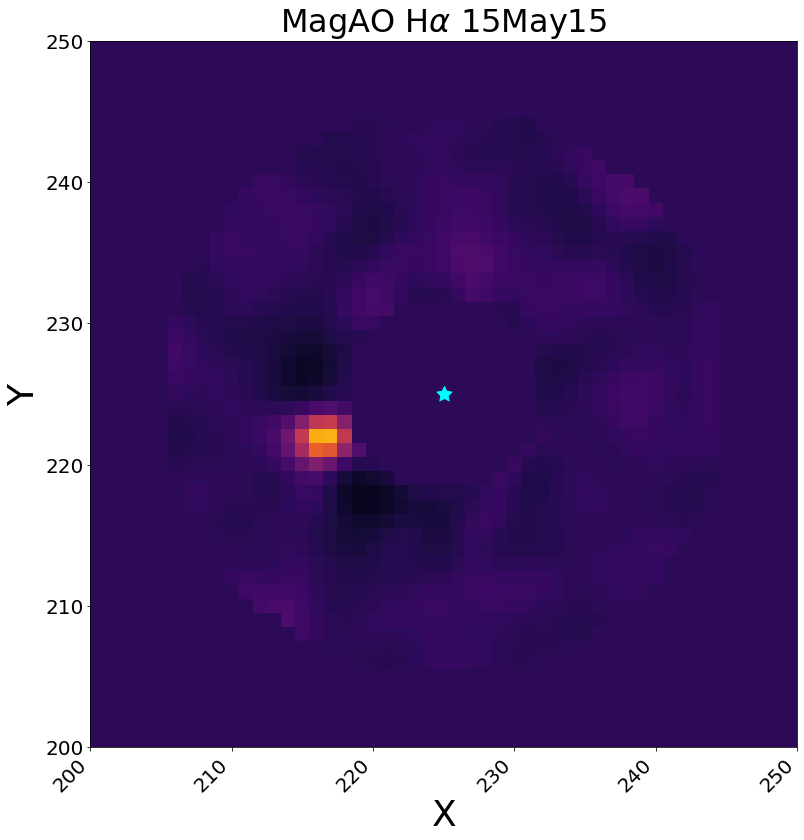

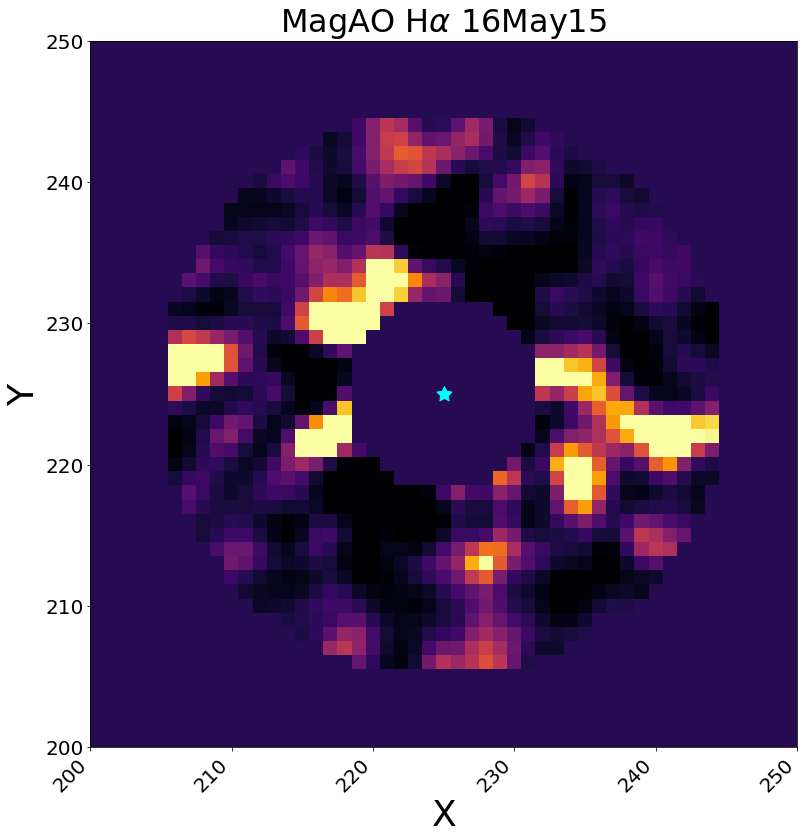

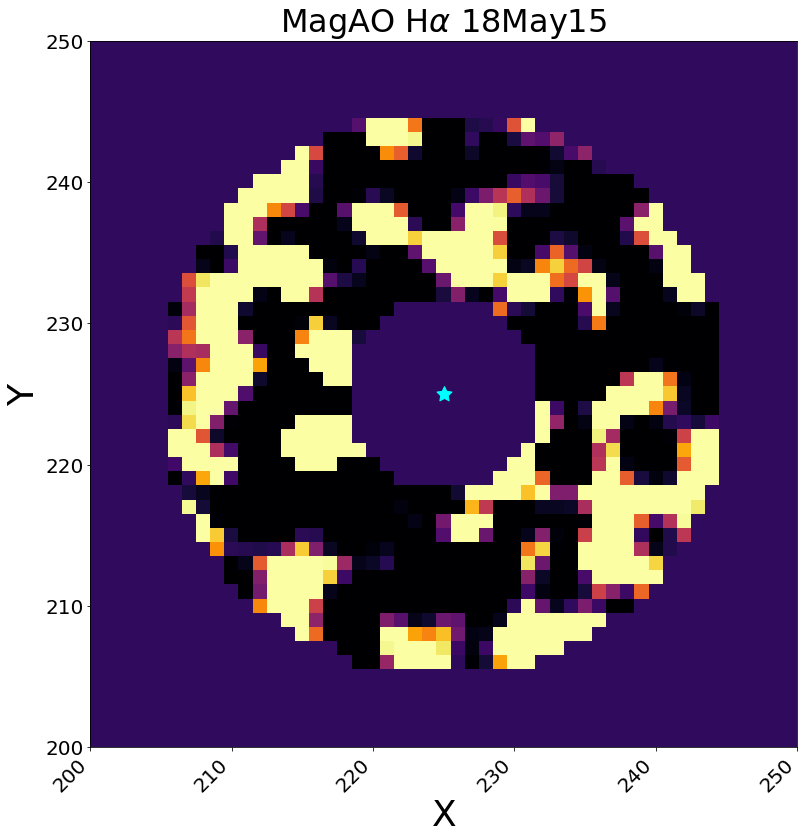

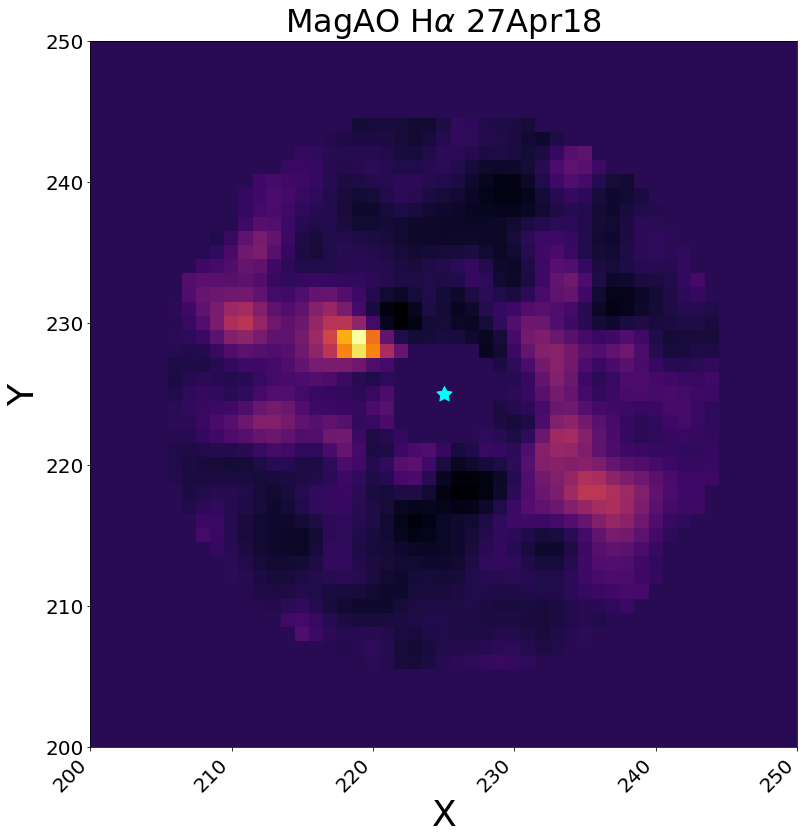

In [71]:
[plot_for_offset(i, saveindiv=True) for i in range(len(imlist))]